In [44]:
import pandas as pd
from pandas import Series, DataFrame
from datetime import datetime
import matplotlib
from matplotlib import pyplot as plt
from shapely.geometry.polygon import Polygon
from shapely.geometry.point import Point
import geopandas
from math import log
from shapely.ops import cascaded_union
from sklearn.linear_model import LinearRegression

In [2]:
#1 take population density of 2019 against crime rates since 2005
population = pd.read_csv('population.csv')
population = population[['Ward', 'total']]
population = population.rename(columns = {'total': 'Population'})
population

,Ward,Population
0,1,2689.607168
1,2,1703.932438
2,3,1172.087254
3,4,987.815762
4,5,1368.445291
...,...,...
139,141,97.774975
140,142,0.000000
141,143,0.000000
142,144,0.000000


In [3]:
population['Population'].sum()
#double checking to make sure total_pop is similar to Madison's population on Google

252969.48787314098

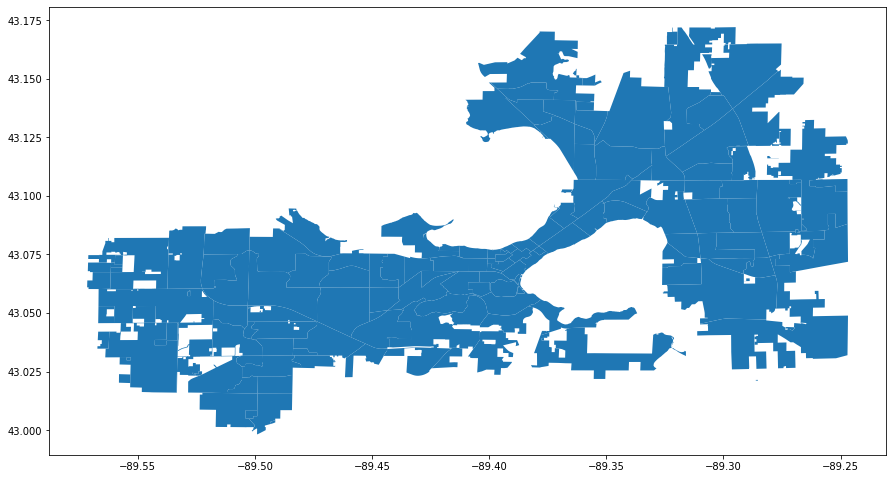

In [4]:
wards = geopandas.read_file("Wards")
wards = wards[['WARD', 'SHAPESTAre', 'geometry' ]].rename(columns = {'WARD': 'Ward', 'SHAPESTAre': 'Area'})
wards = wards.sort_values(by=['Ward']) #sorted in ascending order by ward num

#filtering out wards == -1 
idx_to_drop = []
for idx, row in wards.iterrows():
    if row['Ward'] == -1:
        idx_to_drop.append(idx)

wards = wards.drop(idx_to_drop)
wards.plot(figsize=(15,10)) #cuts represent wards in madison

In [5]:
#fixing the problem of multiple Wards with multiple geometry polygons
#e.g Ward 1 has multiple rows with multople polygons. This combined them into a multipolygon type
seen  = set()
duplicate = []
for idx, row in wards.iterrows():
    if row['Ward'] not in seen:
        seen.add(row['Ward'])
    elif row['Ward'] not in duplicate:
        duplicate.append(row['Ward'])
for idx, row in wards.iterrows():
    if row['Ward'] in duplicate:
        dup_rows = wards[wards['Ward'] == row['Ward']]
        geo = list(dup_rows['geometry'])
        cu = cascaded_union(geo)
        new_area = dup_rows['Area'].sum()
        wards = wards.drop(wards[wards['Ward'] == row['Ward']].index)
        wards = wards.append({'Ward':row['Ward'], 'Area':new_area, 'geometry':cu}, ignore_index=True)

wards = wards.sort_values(by='Ward') #resorting
wards

,Ward,Area,geometry
143,1,1.083861e+08,"MULTIPOLYGON (((-89.28523 43.02113, -89.28616 ..."
0,2,7.327044e+07,"POLYGON ((-89.30625 43.07302, -89.30614 43.072..."
1,3,8.318129e+06,"POLYGON ((-89.27786 43.06610, -89.27840 43.066..."
2,4,7.036292e+06,"POLYGON ((-89.29143 43.06682, -89.29143 43.066..."
3,5,1.367441e+07,"POLYGON ((-89.28662 43.07347, -89.28744 43.073..."
...,...,...,...
138,146,3.145000e+04,"POLYGON ((-89.36689 43.04238, -89.36694 43.042..."
139,148,1.928693e+05,"POLYGON ((-89.49352 43.00347, -89.49331 43.003..."
140,149,3.035465e+04,"POLYGON ((-89.51732 43.06082, -89.51731 43.061..."
141,151,1.723492e+06,"POLYGON ((-89.55318 43.02374, -89.55323 43.020..."


In [6]:
#combining Population and Population Density into one Dataframe
df = pd.merge(wards, population, on='Ward')
df = df[df['Population'] != 0] #filtering away population = 0
df['Population Density'] = df['Population'] / df['Area'] * 1e6 #population density in people per km^2

df

,Ward,Area,geometry,Population,Population Density
0,1,1.083861e+08,"MULTIPOLYGON (((-89.28523 43.02113, -89.28616 ...",2689.607168,24.815063
1,2,7.327044e+07,"POLYGON ((-89.30625 43.07302, -89.30614 43.072...",1703.932438,23.255386
2,3,8.318129e+06,"POLYGON ((-89.27786 43.06610, -89.27840 43.066...",1172.087254,140.907561
3,4,7.036292e+06,"POLYGON ((-89.29143 43.06682, -89.29143 43.066...",987.815762,140.388680
4,5,1.367441e+07,"POLYGON ((-89.28662 43.07347, -89.28744 43.073...",1368.445291,100.073448
...,...,...,...,...,...
131,133,2.049984e+05,"POLYGON ((-89.26806 43.08500, -89.26805 43.084...",10.292103,50.205771
132,134,3.232393e+07,"POLYGON ((-89.25210 43.08643, -89.25210 43.086...",36.022359,1.114418
133,135,2.473199e+05,"POLYGON ((-89.36268 43.15149, -89.36274 43.150...",2.573026,10.403634
134,136,2.678706e+04,"POLYGON ((-89.29059 43.10934, -89.29061 43.108...",2.573026,96.054811


In [7]:
#need to add aggregate crime number over the years to the dataframe
#can check where a certain crime occured by seeing if the coordinate point is within the coordinate geometry
#polygon

In [8]:
coords = pd.read_json('lat_lon.json')
coords = coords.to_dict()

In [9]:
coords['500 Bl S. Park St']


{'lat': 43.067096, 'lng': -89.39992099999999}

In [10]:
#make dict{wardnum: crimenum}
incidents = pd.read_csv('Police_Incident_Reports.csv')
location = incidents['Address']
location

0        700 Block of E. Washington Ave.               ...
1        First St & E Washington Ave                   ...
2        8 New Berm Court                              ...
3        4300 Lumley Rd                                ...
4        211 S. Carroll Street                         ...
                               ...                        
12985                                        30 Ash Street
12986                                         Morrow Court
12987                               636 W. Washington Ave.
12988                               400 block E Johnson St
12989                               200 block S Bedford St
Name: Address, Length: 12990, dtype: object

In [11]:
crime_locs = []
for address in location:
    address = address.rstrip()
    try:
        lat = coords[address]['lat']
        lon = coords[address]['lng']
        point = Point((lon, lat))
        crime_locs.append(point)
    except:
        print('Bad Location: ' , address)
        
print(len(location) - len(crime_locs)) #11 locations are poorly noted (such as a random '0000')

crime_locs #this is a list of points, where each point represents an incident at a certain coordinate
    

Bad Location:  0000
Bad Location:  INS Raid Hoax
Bad Location:  Several Robberies Solved
Bad Location:   700 block Odana Lane
Bad Location:   ** (UPDATE)**     S. Park Street / Regent Street     ** (UPDATE)**  4/2/07
Bad Location:  North Side - Unknown Specific Address (at this time)
Bad Location:  Beltline Crash  **11:45 UPDATE**
Bad Location:  UPDATED 11:20 P.M.  MONDAY JULY 2, 2007
Bad Location:  Update on Marino/Zimmerman Cases
Bad Location:  Multiple Addresses
Bad Location:  Unknown
11


 ...]

In [12]:
df['Crime Count'] = 0 #SLOW 
for point in crime_locs:
    for idx, row in df.iterrows():
        if row['geometry'].contains(point):
            df.loc[idx, 'Crime Count'] += 1
            break

df
            

,Ward,Area,geometry,Population,Population Density,Crime Count
0,1,1.083861e+08,"MULTIPOLYGON (((-89.28523 43.02113, -89.28616 ...",2689.607168,24.815063,78
1,2,7.327044e+07,"POLYGON ((-89.30625 43.07302, -89.30614 43.072...",1703.932438,23.255386,101
2,3,8.318129e+06,"POLYGON ((-89.27786 43.06610, -89.27840 43.066...",1172.087254,140.907561,17
3,4,7.036292e+06,"POLYGON ((-89.29143 43.06682, -89.29143 43.066...",987.815762,140.388680,7
4,5,1.367441e+07,"POLYGON ((-89.28662 43.07347, -89.28744 43.073...",1368.445291,100.073448,49
...,...,...,...,...,...,...
131,133,2.049984e+05,"POLYGON ((-89.26806 43.08500, -89.26805 43.084...",10.292103,50.205771,4
132,134,3.232393e+07,"POLYGON ((-89.25210 43.08643, -89.25210 43.086...",36.022359,1.114418,1
133,135,2.473199e+05,"POLYGON ((-89.36268 43.15149, -89.36274 43.150...",2.573026,10.403634,0
134,136,2.678706e+04,"POLYGON ((-89.29059 43.10934, -89.29061 43.108...",2.573026,96.054811,0


3736.460173155081
coef: [[0.04902592]] intercept: [87.71193543] data points: 125


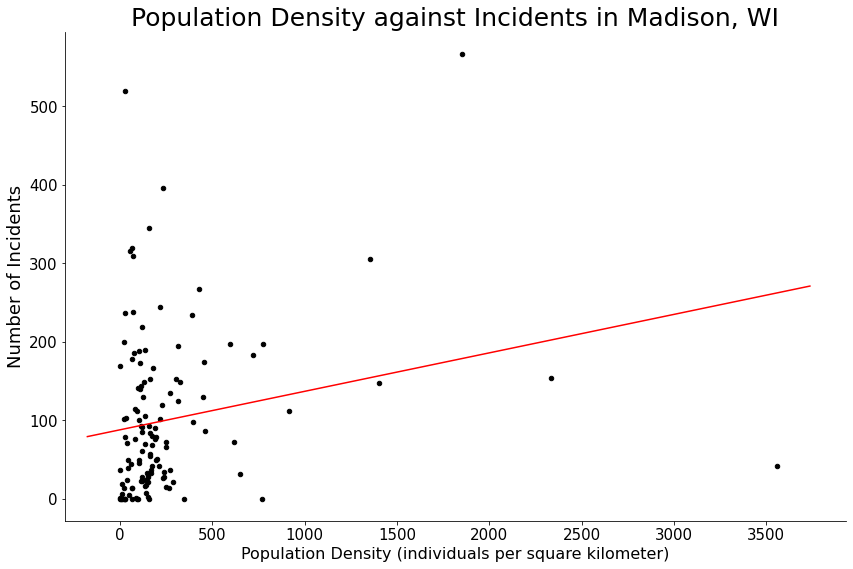

In [13]:
#PLOTTING ALL DATA POINTS AVAILABLE
comparison = df[['Population Density', 'Crime Count']]
fig, ax = plt.subplots(1, figsize = (14,9))

comparison.plot.scatter(ax=ax, x='Population Density', y='Crime Count', color='black')
ax.set_xlabel('Population Density (individuals per square kilometer)', size=16)
ax.set_ylabel('Number of Incidents', size=18)
r = LinearRegression()
r.fit(df['Population Density'].values.reshape(-1,1), df["Crime Count"].values.reshape(-1,1))                                                    
y0 = ax.get_xlim()[0] * r.coef_ + r.intercept_
y1 = ax.get_xlim()[1] * r.coef_ + r.intercept_
print(ax.get_xlim()[1])
ax.plot(ax.get_xlim(), (y0[0], y1[0]), color='red')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlim(left=-300)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.set_title('Population Density against Incidents in Madison, WI', size=25)
print('coef:',r.coef_, 'intercept:', r.intercept_ ,'data points:',len(comparison))



1945.82863285771
coef: [[0.14172482]] intercept: [70.37573063] data points: 123


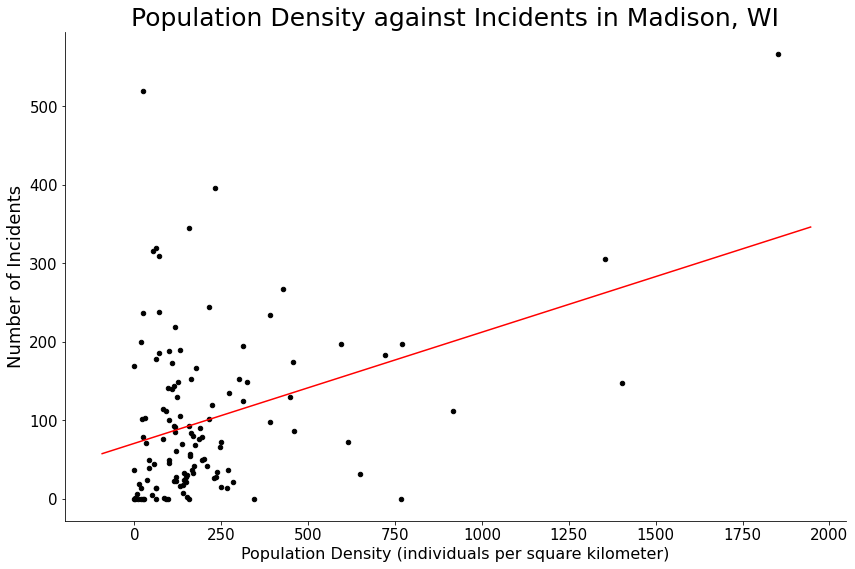

In [14]:
#removing two very high pop densities by looking at pop density < 2000
fig, ax = plt.subplots(1, figsize = (14,9))
comparison = comparison[comparison['Population Density'] <= 2000]
comparison.plot.scatter(ax=ax, x='Population Density', y='Crime Count', color='black')
ax.set_xlabel('Population Density (individuals per square kilometer)', size=16)
ax.set_ylabel('Number of Incidents', size=18)
r = LinearRegression()
r.fit(comparison['Population Density'].values.reshape(-1,1), comparison["Crime Count"].values.reshape(-1,1))                                                    
y0 = ax.get_xlim()[0] * r.coef_ + r.intercept_
y1 = ax.get_xlim()[1] * r.coef_ + r.intercept_
print(ax.get_xlim()[1])
ax.plot(ax.get_xlim(), (y0[0], y1[0]), color='red')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.set_title('Population Density against Incidents in Madison, WI', size=25)
ax.set_xlim(left = -200)
print('coef:',r.coef_, 'intercept:', r.intercept_ ,'data points:',len(comparison))

Text(0.5, 1.0, 'Population Densities in Madison, WI')

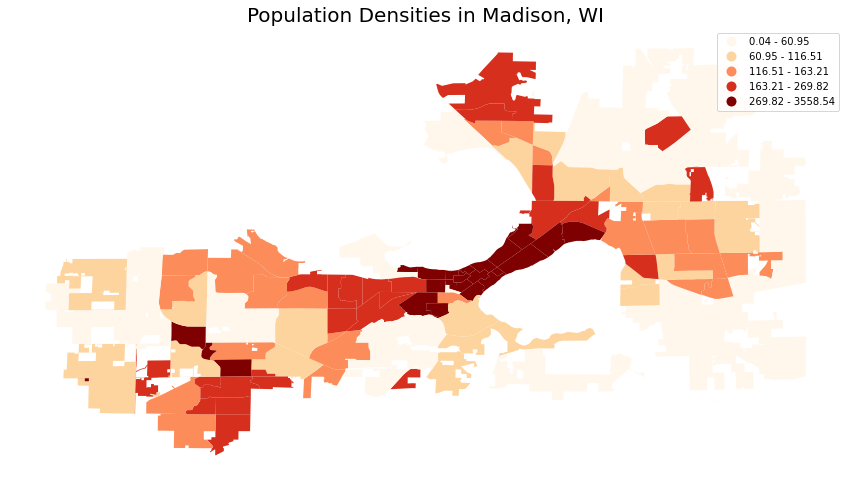

In [41]:
#visual repesentation of population densities
#clearly shows the high concentration of population in campus area
fig, ax = plt.subplots(1, figsize=(15,10))
df.plot(ax=ax, column='Population Density', legend=True, cmap='OrRd', scheme='quantiles')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.xaxis.set_visible(False) 
ax.yaxis.set_visible(False) 
ax.set_title('Population Densities in Madison, WI', size=20)


Text(0.5, 1.0, 'Incidents in Each Ward of Madison, WI')

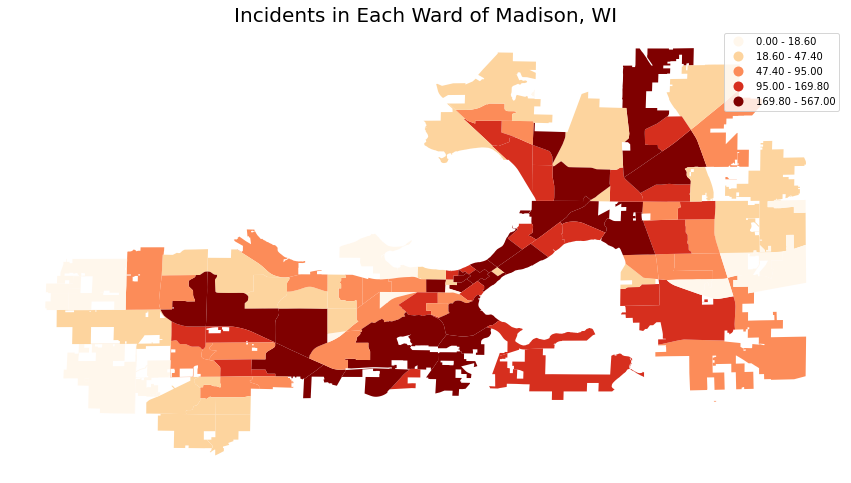

In [50]:
#Same idea but for incidents
matplotlib.rcParams["legend.loc"] = 'upper left' 
fig, ax = plt.subplots(1, figsize=(15,10))
df.plot(ax=ax, column='Crime Count', legend=True, cmap='OrRd', scheme='quantiles')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.xaxis.set_visible(False) 
ax.yaxis.set_visible(False) 
ax.set_title('Incidents in Each Ward of Madison, WI', size=20)